In [14]:
# Import necessary libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [13]:
!pip install scikit-learn


   ---------------------------------------- 0.0/10.9 MB ? eta -:--:--
   ------------------- -------------------- 5.2/10.9 MB 29.0 MB/s eta 0:00:01
   ---------------------------------------- 10.9/10.9 MB 29.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/44.5 MB ? eta -:--:--
   ------- -------------------------------- 8.4/44.5 MB 40.0 MB/s eta 0:00:01
   ----------- ---------------------------- 12.6/44.5 MB 29.2 MB/s eta 0:00:02
   ------------------ --------------------- 20.2/44.5 MB 31.1 MB/s eta 0:00:01
   ------------------------ --------------- 26.7/44.5 MB 31.4 MB/s eta 0:00:01
   ------------------------------- -------- 34.9/44.5 MB 32.6 MB/s eta 0:00:01
   -------------------------------------- - 42.7/44.5 MB 33.2 MB/s eta 0:00:01
   ---------------------------------------- 44.5/44.5 MB 30.1 MB/s eta 0:00:00


In [15]:
# Configure matplotlib and seaborn
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [16]:
# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [49]:
# Check if a GPU is available and set the device accordingly
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("CUDA is available. GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. Using:", torch.device("cpu"))

CUDA is available. GPU: NVIDIA RTX A6000


In [48]:
# Load the dataset
df = pd.read_csv(r"C:\Users\Hardik\Desktop\Sentiment analysis\Twitter_Data.csv")
print(df.head(10))
print(df.tail(10))

                                          clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0
5           kiya tho refresh maarkefir comment karo        0.0
6  surat women perform yagna seeks divine grace f...       0.0
7  this comes from cabinet which has scholars lik...       0.0
8  with upcoming election india saga going import...       1.0
9                         gandhi was gay does modi         1.0
                                               clean_text  category
162970  raga knows dat wont spared modi courts for his...       1.0
162971  congress veteran sudhakar reddy joins bjp afte...       0.0
162972  engine growth modi unveils indias first 12000 ...       1.0
162973  modi promised 2014 lok sabh

In [50]:
# Remove rows with NULL values
df = df.dropna()

# Confirm removal of NULL values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162969 non-null  object 
 1   category    162969 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB
None


In [51]:
!pip install nbformat --upgrade


^C


In [52]:
# Plotting the category graph
import plotly.express as px

category_counts = df['category'].value_counts().reset_index()
category_counts.columns = ['Twitter Category', 'Count']

# fig = px.bar(category_counts,
#              x='Twitter Category',
#              y='Count',
#              labels={'Twitter Category': 'Twitter Category', 'Count': 'Count'},
#              title='Count of Twitter Categories',
#              color='Twitter Category',
#              color_discrete_sequence=["#01BEFE", "#FFDD00", "#FF7D00"])
# fig.show()

In [53]:
# Assigning values from Category to Sentiment
def to_sentiment(rating):
    rating = int(rating)
    if rating == -1:
        return 0
    elif rating == 0:
        return 1
    else:
        return 2

df['sentiment'] = df.category.apply(to_sentiment)
print(df.category.value_counts())

category
 1.0    72249
 0.0    55211
-1.0    35509
Name: count, dtype: int64


In [54]:
# Normalize the entries
g = df.groupby('category')
df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))

# Save the DataFrame to a CSV file
df.to_csv('new_df.csv', index=False)
print(df.category.value_counts())

C:\Users\Hardik\AppData\Local\Temp\ipykernel_26260\2700850409.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



category
-1.0    35509
 0.0    35509
 1.0    35509
Name: count, dtype: int64


In [55]:
# Plotting the sentiment categories
df['sentiment'] = df['sentiment'].astype('category')
category_counts = df['sentiment'].value_counts().reset_index()
category_counts.columns = ['Sentiment', 'Count']

class_names = ['negative', 'neutral', 'positive']
category_counts['Sentiment'] = category_counts['Sentiment'].map(dict(enumerate(class_names)))

# fig = px.bar(category_counts,
#              x='Sentiment',
#              y='Count',
#              labels={'Sentiment': 'Sentiment', 'Count': 'Count'},
#              title='Count of Sentiment Categories',
#              color='Sentiment',
#              color_discrete_sequence=["#01BEFE", "#FFDD00", "#FF7D00"])
# fig.show()

In [56]:
# Shuffling the data
df = df.sample(frac=1).reset_index(drop=True)

In [57]:
# Load the BERT tokenizer
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

c:\Users\Hardik\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



In [58]:
# Define constants
MAX_LEN = 280
BATCH_SIZE = 32

In [59]:
# Create the custom Dataset class and data loader function
class TwitterSentimentDataset(Dataset):
    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets = tweets
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TwitterSentimentDataset(
        tweets=df.clean_text.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=0)  # Set num_workers to 0 to avoid multiprocessing issues

In [60]:
# Split the dataset
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

# Print the shapes of the datasets
print(df_train.shape, df_val.shape, df_test.shape)

(95874, 3) (5326, 3) (5327, 3)


In [61]:
# Create DataLoaders
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Validation:   0%|          | 0/167 [15:29<?, ?it/s]


In [62]:
# Define the SentimentClassifier model
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output[1]
        output = self.drop(pooled_output)
        return self.softmax(self.out(output))

model = SentimentClassifier(len(class_names))
model = model.to(device)

In [63]:
device

device(type='cuda', index=0)

In [67]:
# Training setup
EPOCHS = 50

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [65]:
# Training function
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [66]:
# Evaluation function
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [68]:
from tqdm import tqdm
import os

# Ensure the checkpoints directory exists
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

# Training loop with batch-wise checkpoint saving
history = defaultdict(list)
best_accuracy = 0
save_checkpoint_every = 250  # Set this variable to control checkpoint frequency

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_data_loader = tqdm(train_data_loader, total=len(train_data_loader), desc="Training")
    val_data_loader = tqdm(val_data_loader, total=len(val_data_loader), desc="Validation")

    losses = []
    correct_predictions = 0

    for batch_idx, d in enumerate(train_data_loader):
        model.train()
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        if (batch_idx + 1) % save_checkpoint_every == 0:
            checkpoint_path = f'checkpoints/checkpoint_epoch_{epoch + 1}_batch_{batch_idx + 1}.bin'
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Checkpoint saved at {checkpoint_path}')

    train_acc = correct_predictions.double() / len(df_train)
    train_loss = np.mean(losses)
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/50
----------


Training:   8%|▊         | 250/2997 [01:35<25:07,  1.82it/s]

Checkpoint saved at checkpoints/checkpoint_epoch_1_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:10<22:34,  1.84it/s]

Checkpoint saved at checkpoints/checkpoint_epoch_1_batch_500.bin


Training:  25%|██▌       | 750/2997 [04:45<21:06,  1.77it/s]

Checkpoint saved at checkpoints/checkpoint_epoch_1_batch_750.bin


Training:  33%|███▎      | 1000/2997 [06:23<18:29,  1.80it/s]

Checkpoint saved at checkpoints/checkpoint_epoch_1_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:05<1:06:37,  2.29s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_1_batch_1250.bin


Training:  50%|█████     | 1500/2997 [09:46<57:43,  2.31s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_1_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [11:29<47:30,  2.29s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_1_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:06<11:19,  1.47it/s]

Checkpoint saved at checkpoints/checkpoint_epoch_1_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [14:46<24:53,  2.00s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_1_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [16:27<19:06,  2.31s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_1_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [18:05<05:06,  1.24s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_1_batch_2750.bin


Training: 100%|██████████| 2997/2997 [19:40<00:00,  2.54it/s]


Train loss 0.707573881000529 accuracy 0.8404676971858899


Validation: 100%|██████████| 167/167 [20:03<00:00,  7.20s/it]


Val loss 0.660936466591087 accuracy 0.8897859556890725

Epoch 2/50
----------


Training:   8%|▊         | 250/2997 [01:44<2:08:30,  2.81s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_2_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:31<2:26:18,  3.52s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_2_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:17<2:08:05,  3.42s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_2_batch_750.bin


Training:  33%|███▎      | 1000/2997 [06:59<59:37,  1.79s/it] 

Checkpoint saved at checkpoints/checkpoint_epoch_2_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:44<1:22:50,  2.84s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_2_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:20<13:46,  1.81it/s]  

Checkpoint saved at checkpoints/checkpoint_epoch_2_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [11:57<11:44,  1.77it/s]

Checkpoint saved at checkpoints/checkpoint_epoch_2_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:34<15:01,  1.11it/s]

Checkpoint saved at checkpoints/checkpoint_epoch_2_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:15<22:26,  1.80s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_2_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [16:54<11:05,  1.34s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_2_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [18:36<07:47,  1.89s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_2_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:11<00:00,  2.47it/s]


Train loss 0.6427532351728993 accuracy 0.9078373698813026


Validation: 100%|██████████| 167/167 [20:34<00:00,  7.39s/it]


Val loss 0.641005779811722 accuracy 0.9104393541119039

Epoch 3/50
----------


Training:   8%|▊         | 250/2997 [01:42<1:30:45,  1.98s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_3_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:24<1:28:51,  2.14s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_3_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:06<1:16:43,  2.05s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_3_batch_750.bin


Training:  33%|███▎      | 1000/2997 [06:49<1:09:39,  2.09s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_3_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:31<58:02,  1.99s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_3_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:12<45:24,  1.82s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_3_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [11:57<58:38,  2.82s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_3_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:40<42:19,  2.55s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_3_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:26<38:29,  3.09s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_3_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:11<25:41,  3.10s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_3_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [18:57<12:27,  3.03s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_3_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:32<00:00,  2.43it/s]


Train loss 0.6303261611753597 accuracy 0.9205311137534681


Validation: 100%|██████████| 167/167 [20:55<00:00,  7.52s/it]


Val loss 0.6374977873470968 accuracy 0.9134434847915884

Epoch 4/50
----------


Training:   8%|▊         | 250/2997 [01:44<2:15:27,  2.96s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_4_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:30<2:15:15,  3.25s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_4_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:17<2:04:39,  3.33s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_4_batch_750.bin


Training:  33%|███▎      | 1000/2997 [07:03<1:50:10,  3.31s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_4_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:48<1:29:06,  3.06s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_4_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:33<1:14:17,  2.98s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_4_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:19<1:11:40,  3.45s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_4_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:58<21:58,  1.32s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_4_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:39<21:24,  1.72s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_4_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:25<27:46,  3.35s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_4_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:11<14:09,  3.44s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_4_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:46<00:00,  2.40it/s]


Train loss 0.6253504105953921 accuracy 0.9257462920082609


Validation: 100%|██████████| 167/167 [21:09<00:00,  7.60s/it]


Val loss 0.6374272668433046 accuracy 0.9134434847915884

Epoch 5/50
----------


Training:   8%|▊         | 250/2997 [01:46<2:27:55,  3.23s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_5_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:32<2:20:16,  3.37s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_5_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:19<2:09:16,  3.45s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_5_batch_750.bin


Training:  33%|███▎      | 1000/2997 [07:04<1:40:04,  3.01s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_5_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:49<1:20:47,  2.78s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_5_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:35<1:18:47,  3.16s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_5_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:19<1:00:33,  2.91s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_5_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [14:01<30:03,  1.81s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_5_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:47<40:41,  3.27s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_5_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:32<23:22,  2.82s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_5_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:18<13:43,  3.34s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_5_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:53<00:00,  2.39it/s]


Train loss 0.6213937449502993 accuracy 0.9295533721342596


Validation: 100%|██████████| 167/167 [21:16<00:00,  7.64s/it]


Val loss 0.6284786323587338 accuracy 0.9226436349981224

Epoch 6/50
----------


Training:   8%|▊         | 250/2997 [01:41<1:30:36,  1.98s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_6_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:28<2:21:13,  3.39s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_6_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:13<1:49:58,  2.94s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_6_batch_750.bin


Training:  33%|███▎      | 1000/2997 [06:59<1:46:41,  3.21s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_6_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:45<1:34:55,  3.26s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_6_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:32<1:26:45,  3.48s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_6_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:17<1:06:44,  3.21s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_6_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [14:03<52:43,  3.17s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_6_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:48<39:31,  3.17s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_6_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:33<25:00,  3.02s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_6_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:20<14:16,  3.47s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_6_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:54<00:00,  2.39it/s]


Train loss 0.6187891083675342 accuracy 0.9323278469658093


Validation: 100%|██████████| 167/167 [21:18<00:00,  7.65s/it]


Val loss 0.6280158936620472 accuracy 0.9232069095005633

Epoch 7/50
----------


Training:   8%|▊         | 250/2997 [01:44<2:16:39,  2.98s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_7_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:30<2:12:14,  3.18s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_7_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:16<2:00:54,  3.23s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_7_batch_750.bin


Training:  33%|███▎      | 1000/2997 [07:02<1:50:00,  3.31s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_7_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:48<1:39:21,  3.41s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_7_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:35<1:24:18,  3.38s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_7_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:21<1:11:28,  3.44s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_7_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [14:07<54:55,  3.31s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_7_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:53<39:50,  3.20s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_7_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:38<22:55,  2.77s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_7_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:24<13:40,  3.32s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_7_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:59<00:00,  2.38it/s]


Train loss 0.6190401087572546 accuracy 0.9322444041137327


Validation: 100%|██████████| 167/167 [21:22<00:00,  7.68s/it]


Val loss 0.6241174522274269 accuracy 0.9273375891851295

Epoch 8/50
----------


Training:   8%|▊         | 250/2997 [01:41<1:19:53,  1.74s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_8_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:26<2:06:38,  3.04s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_8_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:12<2:00:29,  3.22s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_8_batch_750.bin


Training:  33%|███▎      | 1000/2997 [06:58<1:41:16,  3.04s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_8_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:38<39:27,  1.36s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_8_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:25<1:25:25,  3.42s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_8_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:09<57:51,  2.78s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_8_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:44<10:22,  1.60it/s]

Checkpoint saved at checkpoints/checkpoint_epoch_8_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:29<39:21,  3.16s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_8_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:13<20:37,  2.49s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_8_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [18:59<13:53,  3.37s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_8_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:34<00:00,  2.43it/s]


Train loss 0.6132227170654325 accuracy 0.9378872269854184


Validation: 100%|██████████| 167/167 [20:57<00:00,  7.53s/it]


Val loss 0.6221578263950919 accuracy 0.9288396545249719

Epoch 9/50
----------


Training:   8%|▊         | 250/2997 [01:47<2:44:30,  3.59s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_9_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:32<2:04:51,  3.00s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_9_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:16<1:40:57,  2.70s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_9_batch_750.bin


Training:  33%|███▎      | 1000/2997 [07:03<1:51:30,  3.35s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_9_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:48<1:25:53,  2.95s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_9_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:33<1:13:48,  2.96s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_9_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:19<1:04:56,  3.12s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_9_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [14:05<53:35,  3.23s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_9_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:49<34:40,  2.79s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_9_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:32<20:44,  2.50s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_9_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:18<13:44,  3.34s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_9_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:53<00:00,  2.39it/s]


Train loss 0.6099733385118516 accuracy 0.9412666624945241


Validation: 100%|██████████| 167/167 [21:16<00:00,  7.64s/it]


Val loss 0.6281512968554468 accuracy 0.9228313931656027

Epoch 10/50
----------


Training:   8%|▊         | 250/2997 [01:45<2:24:11,  3.15s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_10_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:31<2:20:06,  3.37s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_10_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:16<2:01:03,  3.23s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_10_batch_750.bin


Training:  33%|███▎      | 1000/2997 [07:02<1:51:51,  3.36s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_10_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:47<1:23:11,  2.86s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_10_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:34<1:24:30,  3.39s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_10_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:20<1:07:50,  3.26s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_10_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [14:03<39:14,  2.36s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_10_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:49<41:19,  3.32s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_10_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:35<26:13,  3.17s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_10_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:17<08:56,  2.17s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_10_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:53<00:00,  2.39it/s]


Train loss 0.6084475452835495 accuracy 0.9427477731188852


Validation: 100%|██████████| 167/167 [21:16<00:00,  7.64s/it]


Val loss 0.6196130442762089 accuracy 0.9307172361997746

Epoch 11/50
----------


Training:   8%|▊         | 250/2997 [01:41<1:32:34,  2.02s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_11_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:27<2:10:55,  3.15s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_11_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:11<1:46:28,  2.84s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_11_batch_750.bin


Training:  33%|███▎      | 1000/2997 [06:58<1:50:48,  3.33s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_11_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:44<1:39:16,  3.41s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_11_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:30<1:19:51,  3.20s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_11_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:16<1:08:56,  3.32s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_11_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [14:01<51:07,  3.08s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_11_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:46<38:28,  3.09s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_11_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:27<12:58,  1.57s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_11_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:12<11:44,  2.85s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_11_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:47<00:00,  2.40it/s]


Train loss 0.603199840566497 accuracy 0.9480463942257547


Validation: 100%|██████████| 167/167 [21:09<00:00,  7.60s/it]


Val loss 0.6132719541738133 accuracy 0.9380398047315058

Epoch 12/50
----------


Training:   8%|▊         | 250/2997 [01:47<2:35:35,  3.40s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_12_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:33<2:21:21,  3.40s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_12_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:16<1:30:59,  2.43s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_12_batch_750.bin


Training:  33%|███▎      | 1000/2997 [06:59<1:15:29,  2.27s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_12_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:44<1:22:17,  2.83s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_12_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:28<1:07:00,  2.69s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_12_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:14<1:08:40,  3.30s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_12_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:55<29:01,  1.75s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_12_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:41<39:52,  3.20s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_12_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:27<26:44,  3.23s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_12_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:11<11:45,  2.86s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_12_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:46<00:00,  2.40it/s]


Train loss 0.6005802490252194 accuracy 0.950653983353151


Validation: 100%|██████████| 167/167 [21:09<00:00,  7.60s/it]


Val loss 0.6090796143708829 accuracy 0.9419827262485918

Epoch 13/50
----------


Training:   8%|▊         | 250/2997 [01:45<2:24:14,  3.15s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_13_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:28<1:42:30,  2.46s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_13_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:14<2:01:55,  3.26s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_13_batch_750.bin


Training:  33%|███▎      | 1000/2997 [07:01<1:55:07,  3.46s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_13_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:47<1:36:34,  3.32s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_13_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:32<1:17:40,  3.11s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_13_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:12<31:28,  1.51s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_13_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:56<48:38,  2.93s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_13_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:42<39:23,  3.16s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_13_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:26<24:10,  2.92s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_13_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:12<13:50,  3.36s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_13_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:46<00:00,  2.40it/s]


Train loss 0.5972197391328948 accuracy 0.9540855706448047


Validation: 100%|██████████| 167/167 [21:09<00:00,  7.60s/it]


Val loss 0.6068243776966712 accuracy 0.9444235824258356

Epoch 14/50
----------


Training:   8%|▊         | 250/2997 [01:39<1:09:16,  1.51s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_14_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:23<1:53:37,  2.73s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_14_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:09<1:54:21,  3.05s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_14_batch_750.bin


Training:  33%|███▎      | 1000/2997 [06:54<1:46:13,  3.19s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_14_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:36<58:25,  2.01s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_14_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:24<1:30:47,  3.64s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_14_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:09<1:07:41,  3.26s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_14_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:55<54:06,  3.26s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_14_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:40<34:29,  2.77s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_14_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:25<26:19,  3.18s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_14_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:11<13:11,  3.20s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_14_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:46<00:00,  2.40it/s]


Train loss 0.5963859008796063 accuracy 0.9548678473830235


Validation: 100%|██████████| 167/167 [21:10<00:00,  7.61s/it]


Val loss 0.610163847129502 accuracy 0.9414194517461509

Epoch 15/50
----------


Training:   8%|▊         | 250/2997 [01:41<1:19:24,  1.73s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_15_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:27<2:20:51,  3.38s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_15_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:11<1:38:57,  2.64s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_15_batch_750.bin


Training:  33%|███▎      | 1000/2997 [06:57<1:47:55,  3.24s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_15_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:43<1:33:51,  3.22s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_15_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:27<1:08:43,  2.75s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_15_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:14<1:12:47,  3.50s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_15_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:55<31:34,  1.90s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_15_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:42<42:44,  3.43s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_15_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:21<11:34,  1.40s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_15_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:08<14:56,  3.63s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_15_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:43<00:00,  2.41it/s]


Train loss 0.5951842266518075 accuracy 0.9560464776686067


Validation: 100%|██████████| 167/167 [21:06<00:00,  7.58s/it]


Val loss 0.6139959478806593 accuracy 0.9371010138941044

Epoch 16/50
----------


Training:   8%|▊         | 250/2997 [01:44<2:01:30,  2.65s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_16_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:30<2:18:34,  3.33s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_16_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:15<1:55:34,  3.09s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_16_batch_750.bin


Training:  33%|███▎      | 1000/2997 [07:00<1:33:10,  2.80s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_16_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:41<52:51,  1.82s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_16_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:25<1:16:08,  3.05s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_16_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:12<1:10:37,  3.40s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_16_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:58<55:02,  3.31s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_16_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:44<39:41,  3.19s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_16_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:24<11:03,  1.34s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_16_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [18:59<04:30,  1.10s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_16_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:32<00:00,  2.43it/s]


Train loss 0.5953456628589102 accuracy 0.9560256169555875


Validation: 100%|██████████| 167/167 [20:56<00:00,  7.52s/it]


Val loss 0.6075117609458055 accuracy 0.9438603079233947

Epoch 17/50
----------


Training:   8%|▊         | 250/2997 [01:46<2:32:10,  3.32s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_17_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:30<2:02:53,  2.95s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_17_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:17<2:07:20,  3.40s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_17_batch_750.bin


Training:  33%|███▎      | 1000/2997 [06:57<57:50,  1.74s/it] 

Checkpoint saved at checkpoints/checkpoint_epoch_17_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:40<1:14:39,  2.56s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_17_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:25<1:25:17,  3.42s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_17_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:12<1:08:54,  3.32s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_17_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:58<54:48,  3.30s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_17_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:43<40:58,  3.29s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_17_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:25<17:08,  2.07s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_17_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:11<14:12,  3.45s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_17_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:45<00:00,  2.41it/s]


Train loss 0.5948980512283307 accuracy 0.9565054133550285


Validation: 100%|██████████| 167/167 [21:08<00:00,  7.60s/it]


Val loss 0.6048796037713925 accuracy 0.9463011641006384

Epoch 18/50
----------


Training:   8%|▊         | 250/2997 [01:43<2:01:15,  2.65s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_18_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:29<2:20:56,  3.39s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_18_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:15<1:54:16,  3.05s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_18_batch_750.bin


Training:  33%|███▎      | 1000/2997 [06:55<52:45,  1.58s/it] 

Checkpoint saved at checkpoints/checkpoint_epoch_18_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:42<1:40:49,  3.46s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_18_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:27<1:15:31,  3.03s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_18_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:11<55:37,  2.68s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_18_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:58<55:20,  3.33s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_18_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:43<37:58,  3.05s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_18_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:29<26:32,  3.20s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_18_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:15<14:16,  3.47s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_18_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:49<00:00,  2.40it/s]


Train loss 0.5907238914762134 accuracy 0.9605419613242381


Validation: 100%|██████████| 167/167 [21:12<00:00,  7.62s/it]


Val loss 0.6008338589154317 accuracy 0.9502440856177243

Epoch 19/50
----------


Training:   8%|▊         | 250/2997 [01:42<1:37:58,  2.14s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_19_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:26<2:03:18,  2.96s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_19_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:11<1:48:20,  2.89s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_19_batch_750.bin


Training:  33%|███▎      | 1000/2997 [06:56<1:32:39,  2.78s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_19_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:43<1:46:33,  3.66s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_19_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:25<52:41,  2.11s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_19_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:12<1:08:21,  3.29s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_19_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:57<51:42,  3.11s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_19_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:44<41:29,  3.33s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_19_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:30<27:32,  3.32s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_19_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:16<13:49,  3.36s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_19_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:50<00:00,  2.40it/s]


Train loss 0.588679559416957 accuracy 0.962482007635021


Validation: 100%|██████████| 167/167 [21:13<00:00,  7.63s/it]


Val loss 0.6064665167631503 accuracy 0.9446113405933158

Epoch 20/50
----------


Training:   8%|▊         | 250/2997 [01:39<54:22,  1.19s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_20_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:25<2:17:26,  3.30s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_20_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:11<2:01:52,  3.25s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_20_batch_750.bin


Training:  33%|███▎      | 1000/2997 [06:58<1:51:35,  3.35s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_20_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:45<1:42:54,  3.53s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_20_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:32<1:27:48,  3.52s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_20_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:17<1:02:18,  3.00s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_20_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [14:03<55:44,  3.35s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_20_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:50<42:27,  3.41s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_20_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:36<29:04,  3.51s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_20_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:22<13:25,  3.26s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_20_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:57<00:00,  2.38it/s]


Train loss 0.5889637193005205 accuracy 0.9624089951394539


Validation: 100%|██████████| 167/167 [21:20<00:00,  7.67s/it]


Val loss 0.6025400454412677 accuracy 0.9481787457754413

Epoch 21/50
----------


Training:   8%|▊         | 250/2997 [01:43<1:45:45,  2.31s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_21_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:28<2:10:17,  3.13s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_21_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:15<2:20:25,  3.75s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_21_batch_750.bin


Training:  33%|███▎      | 1000/2997 [07:01<1:45:29,  3.17s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_21_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:46<1:23:57,  2.88s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_21_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:32<1:23:53,  3.36s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_21_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:18<1:08:38,  3.30s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_21_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:58<23:32,  1.42s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_21_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:45<41:09,  3.31s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_21_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:29<22:53,  2.76s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_21_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:14<12:56,  3.14s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_21_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:49<00:00,  2.40it/s]


Train loss 0.5871743674392815 accuracy 0.9641612950330642


Validation: 100%|██████████| 167/167 [21:12<00:00,  7.62s/it]


Val loss 0.6029619303292143 accuracy 0.9481787457754413

Epoch 22/50
----------


Training:   8%|▊         | 250/2997 [01:45<2:24:32,  3.16s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_22_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:31<2:20:59,  3.39s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_22_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:16<1:54:01,  3.04s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_22_batch_750.bin


Training:  33%|███▎      | 1000/2997 [07:01<1:41:52,  3.06s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_22_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:48<1:36:05,  3.30s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_22_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:31<1:02:12,  2.49s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_22_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:17<1:02:32,  3.01s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_22_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [14:02<47:29,  2.86s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_22_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:48<42:05,  3.38s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_22_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:32<23:26,  2.83s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_22_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:17<11:38,  2.83s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_22_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:51<00:00,  2.39it/s]


Train loss 0.5869634090004502 accuracy 0.9644116235892943


Validation: 100%|██████████| 167/167 [21:14<00:00,  7.63s/it]


Val loss 0.600926329275805 accuracy 0.9502440856177243

Epoch 23/50
----------


Training:   8%|▊         | 250/2997 [01:37<25:17,  1.81it/s]

Checkpoint saved at checkpoints/checkpoint_epoch_23_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:16<52:29,  1.26s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_23_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:01<1:40:07,  2.67s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_23_batch_750.bin


Training:  33%|███▎      | 1000/2997 [06:47<1:51:51,  3.36s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_23_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:28<52:55,  1.82s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_23_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:13<1:10:29,  2.83s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_23_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:00<1:09:27,  3.34s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_23_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:46<56:35,  3.41s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_23_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:33<43:15,  3.47s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_23_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:19<25:04,  3.03s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_23_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:02<10:08,  2.46s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_23_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:37<00:00,  2.42it/s]


Train loss 0.5870871541895467 accuracy 0.964244737885141


Validation: 100%|██████████| 167/167 [21:00<00:00,  7.55s/it]


Val loss 0.6012302890509188 accuracy 0.9498685692827638

Epoch 24/50
----------


Training:   8%|▊         | 250/2997 [01:40<1:02:30,  1.37s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_24_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:21<1:17:27,  1.86s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_24_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:04<1:34:32,  2.52s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_24_batch_750.bin


Training:  33%|███▎      | 1000/2997 [06:51<1:51:14,  3.34s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_24_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:37<1:35:07,  3.27s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_24_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:22<1:20:15,  3.22s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_24_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:08<1:01:55,  2.98s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_24_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:53<49:08,  2.96s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_24_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:36<31:17,  2.51s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_24_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:22<27:20,  3.30s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_24_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:08<13:23,  3.25s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_24_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:42<00:00,  2.41it/s]


Train loss 0.5875757020992322 accuracy 0.9636502075640946


Validation: 100%|██████████| 167/167 [21:06<00:00,  7.58s/it]


Val loss 0.6006156937804764 accuracy 0.9506196019526849

Epoch 25/50
----------


Training:   8%|▊         | 250/2997 [01:45<2:15:44,  2.96s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_25_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:31<2:17:34,  3.31s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_25_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:17<2:09:10,  3.45s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_25_batch_750.bin


Training:  33%|███▎      | 1000/2997 [07:03<1:45:41,  3.18s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_25_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:47<1:20:23,  2.76s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_25_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:34<1:25:39,  3.43s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_25_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:20<1:08:47,  3.31s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_25_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [14:04<45:30,  2.74s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_25_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:50<37:02,  2.98s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_25_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:35<25:38,  3.09s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_25_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:19<10:41,  2.60s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_25_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:54<00:00,  2.39it/s]


Train loss 0.5861285971648541 accuracy 0.9652773431795899


Validation: 100%|██████████| 167/167 [21:17<00:00,  7.65s/it]


Val loss 0.5997622030937743 accuracy 0.9515583927900864

Epoch 26/50
----------


Training:   8%|▊         | 250/2997 [01:46<2:38:26,  3.46s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_26_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:31<2:01:46,  2.93s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_26_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:17<2:00:08,  3.21s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_26_batch_750.bin


Training:  33%|███▎      | 1000/2997 [07:03<1:46:53,  3.21s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_26_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:49<1:38:14,  3.37s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_26_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:35<1:21:01,  3.25s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_26_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:20<1:03:03,  3.03s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_26_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [14:06<54:08,  3.26s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_26_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:46<20:29,  1.65s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_26_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:32<27:06,  3.27s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_26_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:18<13:55,  3.38s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_26_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:52<00:00,  2.39it/s]


Train loss 0.585837397907112 accuracy 0.965475519953272


Validation: 100%|██████████| 167/167 [21:15<00:00,  7.64s/it]


Val loss 0.603788664954865 accuracy 0.9476154712730004

Epoch 27/50
----------


Training:   8%|▊         | 250/2997 [01:45<2:21:41,  3.09s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_27_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:30<2:22:14,  3.42s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_27_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:16<1:58:05,  3.15s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_27_batch_750.bin


Training:  33%|███▎      | 1000/2997 [06:59<1:23:18,  2.50s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_27_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:43<1:26:39,  2.98s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_27_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:27<1:11:37,  2.87s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_27_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:11<1:00:21,  2.90s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_27_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:56<49:42,  2.99s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_27_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:41<34:29,  2.77s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_27_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:23<18:34,  2.24s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_27_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:09<13:06,  3.18s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_27_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:44<00:00,  2.41it/s]


Train loss 0.5843566268891305 accuracy 0.9669253395081044


Validation: 100%|██████████| 167/167 [21:07<00:00,  7.59s/it]


Val loss 0.5995608439702473 accuracy 0.9515583927900864

Epoch 28/50
----------


Training:   8%|▊         | 250/2997 [01:45<2:10:38,  2.85s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_28_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:29<2:03:54,  2.98s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_28_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:16<2:01:42,  3.25s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_28_batch_750.bin


Training:  33%|███▎      | 1000/2997 [07:01<1:37:54,  2.94s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_28_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:45<1:22:14,  2.82s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_28_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:30<1:14:19,  2.98s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_28_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:17<1:09:54,  3.36s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_28_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [14:02<53:24,  3.21s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_28_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:46<31:29,  2.53s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_28_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:29<19:12,  2.32s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_28_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:15<13:41,  3.33s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_28_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:49<00:00,  2.40it/s]


Train loss 0.5835345903356194 accuracy 0.9677180466028329


Validation: 100%|██████████| 167/167 [21:12<00:00,  7.62s/it]


Val loss 0.5979722338522265 accuracy 0.9536237326323695

Epoch 29/50
----------


Training:   8%|▊         | 250/2997 [01:44<2:11:16,  2.87s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_29_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:30<2:14:34,  3.23s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_29_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:14<1:40:11,  2.68s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_29_batch_750.bin


Training:  33%|███▎      | 1000/2997 [06:57<1:21:26,  2.45s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_29_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:43<1:32:50,  3.19s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_29_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:29<1:18:37,  3.15s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_29_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:15<1:10:14,  3.38s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_29_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [14:01<54:27,  3.28s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_29_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:43<24:50,  2.00s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_29_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:25<18:15,  2.20s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_29_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:11<12:56,  3.14s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_29_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:46<00:00,  2.41it/s]


Train loss 0.5820167141633706 accuracy 0.9692930304357803


Validation: 100%|██████████| 167/167 [21:09<00:00,  7.60s/it]


Val loss 0.6005292117238759 accuracy 0.9498685692827638

Epoch 30/50
----------


Training:   8%|▊         | 250/2997 [01:46<2:29:19,  3.26s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_30_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:30<1:56:30,  2.80s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_30_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:11<1:09:15,  1.85s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_30_batch_750.bin


Training:  33%|███▎      | 1000/2997 [06:58<1:53:13,  3.40s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_30_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:42<1:17:17,  2.65s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_30_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:28<1:18:35,  3.15s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_30_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:13<1:06:54,  3.22s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_30_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:59<51:43,  3.11s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_30_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:44<37:30,  3.01s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_30_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:25<14:32,  1.76s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_30_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:11<13:34,  3.30s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_30_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:46<00:00,  2.40it/s]


Train loss 0.5815468875217088 accuracy 0.9698458393307884


Validation: 100%|██████████| 167/167 [21:09<00:00,  7.60s/it]


Val loss 0.5972378821430092 accuracy 0.9538114907998498

Epoch 31/50
----------


Training:   8%|▊         | 250/2997 [01:45<2:13:40,  2.92s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_31_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:31<2:19:37,  3.36s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_31_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:12<1:09:10,  1.85s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_31_batch_750.bin


Training:  33%|███▎      | 1000/2997 [06:51<55:29,  1.67s/it] 

Checkpoint saved at checkpoints/checkpoint_epoch_31_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:37<1:32:34,  3.18s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_31_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:24<1:28:08,  3.53s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_31_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:07<51:03,  2.46s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_31_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:52<48:55,  2.94s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_31_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:39<42:02,  3.38s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_31_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:24<24:26,  2.95s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_31_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:09<12:20,  3.00s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_31_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:44<00:00,  2.41it/s]


Train loss 0.5809348287843329 accuracy 0.9704612303648539


Validation: 100%|██████████| 167/167 [21:07<00:00,  7.59s/it]


Val loss 0.5960187551504124 accuracy 0.9551257979722118

Epoch 32/50
----------


Training:   8%|▊         | 250/2997 [01:43<1:56:52,  2.55s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_32_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:29<2:16:08,  3.27s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_32_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:08<48:23,  1.29s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_32_batch_750.bin


Training:  33%|███▎      | 1000/2997 [06:54<1:50:03,  3.31s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_32_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:40<1:34:26,  3.24s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_32_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:25<1:21:19,  3.26s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_32_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:10<1:01:09,  2.94s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_32_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:55<53:49,  3.24s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_32_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:41<40:11,  3.23s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_32_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:26<26:52,  3.24s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_32_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:10<10:14,  2.49s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_32_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:45<00:00,  2.41it/s]


Train loss 0.5812303579008734 accuracy 0.9701900410956047


Validation: 100%|██████████| 167/167 [21:08<00:00,  7.59s/it]


Val loss 0.596166949786112 accuracy 0.9551257979722118

Epoch 33/50
----------


Training:   8%|▊         | 250/2997 [01:46<2:29:07,  3.26s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_33_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:31<2:18:17,  3.32s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_33_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:16<1:45:31,  2.82s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_33_batch_750.bin


Training:  33%|███▎      | 1000/2997 [07:02<1:52:06,  3.37s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_33_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:47<1:25:44,  2.94s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_33_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:33<1:19:03,  3.17s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_33_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:17<58:29,  2.81s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_33_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [14:03<53:33,  3.22s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_33_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:48<39:13,  3.15s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_33_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:29<14:51,  1.79s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_33_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:15<12:14,  2.97s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_33_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:49<00:00,  2.40it/s]


Train loss 0.5806654754542573 accuracy 0.970711558921084


Validation: 100%|██████████| 167/167 [21:12<00:00,  7.62s/it]


Val loss 0.5960399872528579 accuracy 0.955313556139692

Epoch 34/50
----------


Training:   8%|▊         | 250/2997 [01:45<2:15:10,  2.95s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_34_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:29<1:52:44,  2.71s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_34_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:14<1:48:56,  2.91s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_34_batch_750.bin


Training:  33%|███▎      | 1000/2997 [07:00<1:49:10,  3.28s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_34_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:46<1:34:25,  3.24s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_34_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:30<1:09:06,  2.77s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_34_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:16<1:06:19,  3.19s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_34_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [14:01<49:53,  3.00s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_34_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:41<17:51,  1.43s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_34_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:24<20:06,  2.43s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_34_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:10<13:07,  3.19s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_34_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:45<00:00,  2.41it/s]


Train loss 0.5805332628058559 accuracy 0.9708888749817469


Validation: 100%|██████████| 167/167 [21:08<00:00,  7.60s/it]


Val loss 0.5954465402100615 accuracy 0.9556890724746526

Epoch 35/50
----------


Training:   8%|▊         | 250/2997 [01:45<2:16:29,  2.98s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_35_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:30<2:12:52,  3.19s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_35_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:12<1:15:54,  2.03s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_35_batch_750.bin


Training:  33%|███▎      | 1000/2997 [06:58<1:46:20,  3.19s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_35_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:43<1:20:06,  2.75s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_35_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:28<1:20:44,  3.24s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_35_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:13<1:00:21,  2.90s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_35_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [14:00<54:45,  3.30s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_35_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:44<34:48,  2.80s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_35_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:29<23:48,  2.87s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_35_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:15<13:40,  3.32s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_35_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:50<00:00,  2.40it/s]


Train loss 0.5801728541627501 accuracy 0.9712017856770344


Validation: 100%|██████████| 167/167 [21:13<00:00,  7.63s/it]


Val loss 0.5951232492566823 accuracy 0.9555013143071723

Epoch 36/50
----------


Training:   8%|▊         | 250/2997 [01:44<2:07:30,  2.79s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_36_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:30<2:20:14,  3.37s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_36_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:17<2:09:15,  3.45s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_36_batch_750.bin


Training:  33%|███▎      | 1000/2997 [07:00<1:28:36,  2.66s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_36_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:45<1:26:34,  2.97s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_36_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:29<1:04:02,  2.57s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_36_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:15<1:09:04,  3.32s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_36_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [14:00<50:03,  3.01s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_36_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:46<38:51,  3.12s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_36_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:32<26:35,  3.21s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_36_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:18<13:53,  3.37s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_36_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:53<00:00,  2.39it/s]


Train loss 0.5797293101464426 accuracy 0.9716607213634563


Validation: 100%|██████████| 167/167 [21:16<00:00,  7.65s/it]


Val loss 0.5962117242955876 accuracy 0.9551257979722118

Epoch 37/50
----------


Training:   8%|▊         | 250/2997 [01:46<2:33:38,  3.36s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_37_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:32<2:21:18,  3.40s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_37_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:17<1:45:14,  2.81s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_37_batch_750.bin


Training:  33%|███▎      | 1000/2997 [07:03<1:49:03,  3.28s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_37_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:49<1:35:42,  3.29s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_37_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:34<1:18:36,  3.15s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_37_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:19<1:01:45,  2.97s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_37_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [14:05<53:37,  3.23s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_37_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:51<39:29,  3.17s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_37_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:36<26:18,  3.18s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_37_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:20<11:04,  2.69s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_37_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:55<00:00,  2.39it/s]


Train loss 0.579045380438651 accuracy 0.9723908463191272


Validation: 100%|██████████| 167/167 [21:18<00:00,  7.66s/it]


Val loss 0.5962925753193701 accuracy 0.9547502816372512

Epoch 38/50
----------


Training:   8%|▊         | 250/2997 [01:45<2:21:30,  3.09s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_38_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:29<1:58:20,  2.84s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_38_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:16<2:14:09,  3.58s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_38_batch_750.bin


Training:  33%|███▎      | 1000/2997 [07:01<1:43:14,  3.10s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_38_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:47<1:36:34,  3.32s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_38_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:31<1:11:56,  2.88s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_38_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:14<50:12,  2.42s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_38_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:59<51:39,  3.11s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_38_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:43<32:58,  2.65s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_38_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:26<20:13,  2.44s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_38_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:09<09:49,  2.39s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_38_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:44<00:00,  2.41it/s]


Train loss 0.5786625618213886 accuracy 0.9727037570144148


Validation: 100%|██████████| 167/167 [21:07<00:00,  7.59s/it]


Val loss 0.5947935613329539 accuracy 0.9564401051445738

Epoch 39/50
----------


Training:   8%|▊         | 250/2997 [01:45<2:23:20,  3.13s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_39_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:32<2:18:57,  3.34s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_39_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:16<1:43:00,  2.75s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_39_batch_750.bin


Training:  33%|███▎      | 1000/2997 [07:00<1:25:31,  2.57s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_39_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:41<50:27,  1.73s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_39_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:27<1:19:24,  3.18s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_39_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:12<1:04:20,  3.10s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_39_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:57<50:08,  3.02s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_39_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:43<39:26,  3.17s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_39_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:27<22:06,  2.67s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_39_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:12<12:29,  3.03s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_39_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:47<00:00,  2.40it/s]


Train loss 0.5783168088805091 accuracy 0.9731105409182886


Validation: 100%|██████████| 167/167 [21:10<00:00,  7.61s/it]


Val loss 0.5945800685597037 accuracy 0.9568156214795344

Epoch 40/50
----------


Training:   8%|▊         | 250/2997 [01:44<2:06:20,  2.76s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_40_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:31<2:21:09,  3.39s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_40_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:17<2:06:22,  3.37s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_40_batch_750.bin


Training:  33%|███▎      | 1000/2997 [07:01<1:33:22,  2.81s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_40_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:47<1:35:07,  3.27s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_40_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:33<1:24:10,  3.37s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_40_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:19<1:03:13,  3.04s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_40_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [14:04<49:39,  2.99s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_40_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:49<38:54,  3.13s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_40_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:30<14:07,  1.70s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_40_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:15<10:55,  2.65s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_40_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:50<00:00,  2.40it/s]


Train loss 0.5781121471543132 accuracy 0.973277426622442


Validation: 100%|██████████| 167/167 [21:13<00:00,  7.62s/it]


Val loss 0.5949570961341173 accuracy 0.9562523469770935

Epoch 41/50
----------


Training:   8%|▊         | 250/2997 [01:46<2:34:52,  3.38s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_41_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:30<2:01:39,  2.92s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_41_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:16<1:59:18,  3.19s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_41_batch_750.bin


Training:  33%|███▎      | 1000/2997 [07:02<1:44:06,  3.13s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_41_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:46<1:19:24,  2.73s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_41_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:32<1:17:05,  3.09s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_41_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:17<1:06:18,  3.19s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_41_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [14:04<55:09,  3.32s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_41_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:48<37:13,  2.99s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_41_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:35<27:42,  3.34s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_41_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:21<12:31,  3.04s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_41_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:55<00:00,  2.39it/s]


Train loss 0.5779103837412598 accuracy 0.9735277551786721


Validation: 100%|██████████| 167/167 [21:18<00:00,  7.66s/it]


Val loss 0.5961124854173488 accuracy 0.9549380398047315

Epoch 42/50
----------


Training:   8%|▊         | 250/2997 [01:46<2:25:24,  3.18s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_42_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:29<1:39:10,  2.38s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_42_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:14<1:45:35,  2.82s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_42_batch_750.bin


Training:  33%|███▎      | 1000/2997 [07:00<1:50:17,  3.31s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_42_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:44<1:18:04,  2.68s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_42_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:27<59:32,  2.39s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_42_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:14<1:10:11,  3.38s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_42_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:53<28:34,  1.72s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_42_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:38<35:33,  2.86s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_42_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:21<19:06,  2.31s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_42_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:07<12:53,  3.13s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_42_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:42<00:00,  2.41it/s]


Train loss 0.5777431859308216 accuracy 0.973652919456787


Validation: 100%|██████████| 167/167 [21:05<00:00,  7.58s/it]


Val loss 0.5938683355639794 accuracy 0.9571911378144949

Epoch 43/50
----------


Training:   8%|▊         | 250/2997 [01:45<2:25:20,  3.17s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_43_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:26<1:13:20,  1.76s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_43_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:09<1:23:27,  2.23s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_43_batch_750.bin


Training:  33%|███▎      | 1000/2997 [06:56<1:50:36,  3.32s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_43_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:41<1:22:29,  2.83s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_43_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:26<1:12:11,  2.89s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_43_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:06<35:12,  1.69s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_43_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:53<56:28,  3.40s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_43_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:37<33:12,  2.67s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_43_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:23<25:12,  3.04s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_43_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:08<12:52,  3.13s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_43_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:43<00:00,  2.41it/s]


Train loss 0.5775184849520146 accuracy 0.9738928176565075


Validation: 100%|██████████| 167/167 [21:06<00:00,  7.58s/it]


Val loss 0.5926286813741672 accuracy 0.9586932031543373

Epoch 44/50
----------


Training:   8%|▊         | 250/2997 [01:45<2:23:27,  3.13s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_44_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:29<1:54:01,  2.74s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_44_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:15<2:02:35,  3.27s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_44_batch_750.bin


Training:  33%|███▎      | 1000/2997 [07:00<1:48:12,  3.25s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_44_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:44<1:22:09,  2.82s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_44_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:24<36:47,  1.47s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_44_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:09<1:03:23,  3.05s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_44_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:54<51:54,  3.12s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_44_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:39<39:00,  3.13s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_44_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:25<27:01,  3.26s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_44_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:03<04:50,  1.18s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_44_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:38<00:00,  2.42it/s]


Train loss 0.5771554541818532 accuracy 0.9742474497778334


Validation: 100%|██████████| 167/167 [21:01<00:00,  7.55s/it]


Val loss 0.5943958505898893 accuracy 0.9566278633120541

Epoch 45/50
----------


Training:   8%|▊         | 250/2997 [01:41<1:29:25,  1.95s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_45_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:26<2:04:53,  3.00s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_45_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:11<1:55:29,  3.08s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_45_batch_750.bin


Training:  33%|███▎      | 1000/2997 [06:57<1:44:25,  3.14s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_45_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:41<1:18:49,  2.71s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_45_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:26<1:18:08,  3.13s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_45_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:11<1:07:06,  3.23s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_45_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:54<36:36,  2.20s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_45_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:39<38:37,  3.10s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_45_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:25<26:53,  3.25s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_45_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:10<12:58,  3.15s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_45_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:45<00:00,  2.41it/s]


Train loss 0.576882959486128 accuracy 0.9745394997601018


Validation: 100%|██████████| 167/167 [21:08<00:00,  7.60s/it]


Val loss 0.593535154522536 accuracy 0.9577544123169358

Epoch 46/50
----------


Training:   8%|▊         | 250/2997 [01:43<1:52:31,  2.46s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_46_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:29<2:12:00,  3.17s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_46_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:15<2:00:14,  3.21s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_46_batch_750.bin


Training:  33%|███▎      | 1000/2997 [07:00<1:47:39,  3.23s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_46_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:44<1:21:26,  2.80s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_46_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:31<1:21:23,  3.26s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_46_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:16<1:06:27,  3.20s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_46_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [14:00<43:45,  2.63s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_46_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:46<40:28,  3.25s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_46_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:32<28:25,  3.43s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_46_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:16<10:56,  2.66s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_46_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:51<00:00,  2.40it/s]


Train loss 0.5767310566412118 accuracy 0.9746542336817072


Validation: 100%|██████████| 167/167 [21:14<00:00,  7.63s/it]


Val loss 0.5918341643082168 accuracy 0.959256477656778

Epoch 47/50
----------


Training:   8%|▊         | 250/2997 [01:45<2:19:00,  3.04s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_47_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:31<2:13:11,  3.20s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_47_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:17<2:02:35,  3.27s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_47_batch_750.bin


Training:  33%|███▎      | 1000/2997 [07:02<1:41:15,  3.04s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_47_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:49<1:44:17,  3.58s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_47_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:34<1:21:00,  3.25s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_47_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:19<58:41,  2.82s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_47_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [14:04<50:48,  3.06s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_47_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:50<39:09,  3.15s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_47_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:32<18:22,  2.22s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_47_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:17<12:31,  3.04s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_47_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:52<00:00,  2.39it/s]


Train loss 0.5764426390329996 accuracy 0.9749567140204852


Validation: 100%|██████████| 167/167 [21:15<00:00,  7.64s/it]


Val loss 0.5931276964570233 accuracy 0.9577544123169358

Epoch 48/50
----------


Training:   8%|▊         | 250/2997 [01:44<2:05:34,  2.74s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_48_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:29<2:07:48,  3.07s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_48_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:12<1:30:32,  2.42s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_48_batch_750.bin


Training:  33%|███▎      | 1000/2997 [06:57<1:40:38,  3.02s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_48_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:43<1:37:41,  3.35s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_48_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:29<1:19:26,  3.18s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_48_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:13<58:07,  2.80s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_48_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [14:00<56:20,  3.39s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_48_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:46<43:33,  3.50s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_48_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:31<24:34,  2.97s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_48_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:17<13:34,  3.30s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_48_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:51<00:00,  2.39it/s]


Train loss 0.5765304065243896 accuracy 0.9748732711684085


Validation: 100%|██████████| 167/167 [21:14<00:00,  7.63s/it]


Val loss 0.5931873510697645 accuracy 0.9577544123169358

Epoch 49/50
----------


Training:   8%|▊         | 250/2997 [01:44<2:18:31,  3.03s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_49_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:27<1:32:43,  2.23s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_49_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:12<1:48:40,  2.90s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_49_batch_750.bin


Training:  33%|███▎      | 1000/2997 [06:56<1:35:52,  2.88s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_49_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:42<1:39:37,  3.42s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_49_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:26<1:06:32,  2.67s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_49_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:06<32:11,  1.55s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_49_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:52<56:40,  3.41s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_49_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:37<37:32,  3.02s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_49_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:22<24:44,  2.99s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_49_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:07<12:48,  3.11s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_49_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:42<00:00,  2.41it/s]


Train loss 0.5763350163335039 accuracy 0.9751027390116195


Validation: 100%|██████████| 167/167 [21:05<00:00,  7.58s/it]


Val loss 0.5933021803102093 accuracy 0.9579421704844161

Epoch 50/50
----------


Training:   8%|▊         | 250/2997 [01:44<2:20:26,  3.07s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_50_batch_250.bin


Training:  17%|█▋        | 500/2997 [03:30<2:09:39,  3.12s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_50_batch_500.bin


Training:  25%|██▌       | 750/2997 [05:14<1:43:51,  2.77s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_50_batch_750.bin


Training:  33%|███▎      | 1000/2997 [06:59<1:43:35,  3.11s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_50_batch_1000.bin


Training:  42%|████▏     | 1250/2997 [08:44<1:27:02,  2.99s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_50_batch_1250.bin


Training:  50%|█████     | 1500/2997 [10:26<1:00:20,  2.42s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_50_batch_1500.bin


Training:  58%|█████▊    | 1750/2997 [12:13<1:12:34,  3.49s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_50_batch_1750.bin


Training:  67%|██████▋   | 2000/2997 [13:57<51:00,  3.07s/it]  

Checkpoint saved at checkpoints/checkpoint_epoch_50_batch_2000.bin


Training:  75%|███████▌  | 2250/2997 [15:41<35:54,  2.88s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_50_batch_2250.bin


Training:  83%|████████▎ | 2500/2997 [17:27<26:45,  3.23s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_50_batch_2500.bin


Training:  92%|█████████▏| 2750/2997 [19:12<13:03,  3.17s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_50_batch_2750.bin


Training: 100%|██████████| 2997/2997 [20:46<00:00,  2.40it/s]


Train loss 0.5762529185027491 accuracy 0.9751653211506769


Validation: 100%|██████████| 167/167 [21:09<00:00,  7.60s/it]

Val loss 0.5930285443088965 accuracy 0.9579421704844161



In [69]:
# Load the best model state
model.load_state_dict(torch.load('best_model_state.bin'))

# Testing the model
test_acc, _ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)

print(f'Test Accuracy: {test_acc.item()}')

C:\Users\Hardik\AppData\Local\Temp\ipykernel_26260\3204998896.py:2: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Test Accuracy: 0.9588886803078656


In [70]:
# Function to get predictions 
def get_predictions(model, data_loader):
    model = model.eval()

    tweet_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["tweet_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            tweet_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)


    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return tweet_texts, predictions, prediction_probs, real_values


In [71]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

# Classification report
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

    negative       0.96      0.95      0.95      1731
     neutral       0.95      0.98      0.96      1757
    positive       0.97      0.95      0.96      1839

    accuracy                           0.96      5327
   macro avg       0.96      0.96      0.96      5327
weighted avg       0.96      0.96      0.96      5327



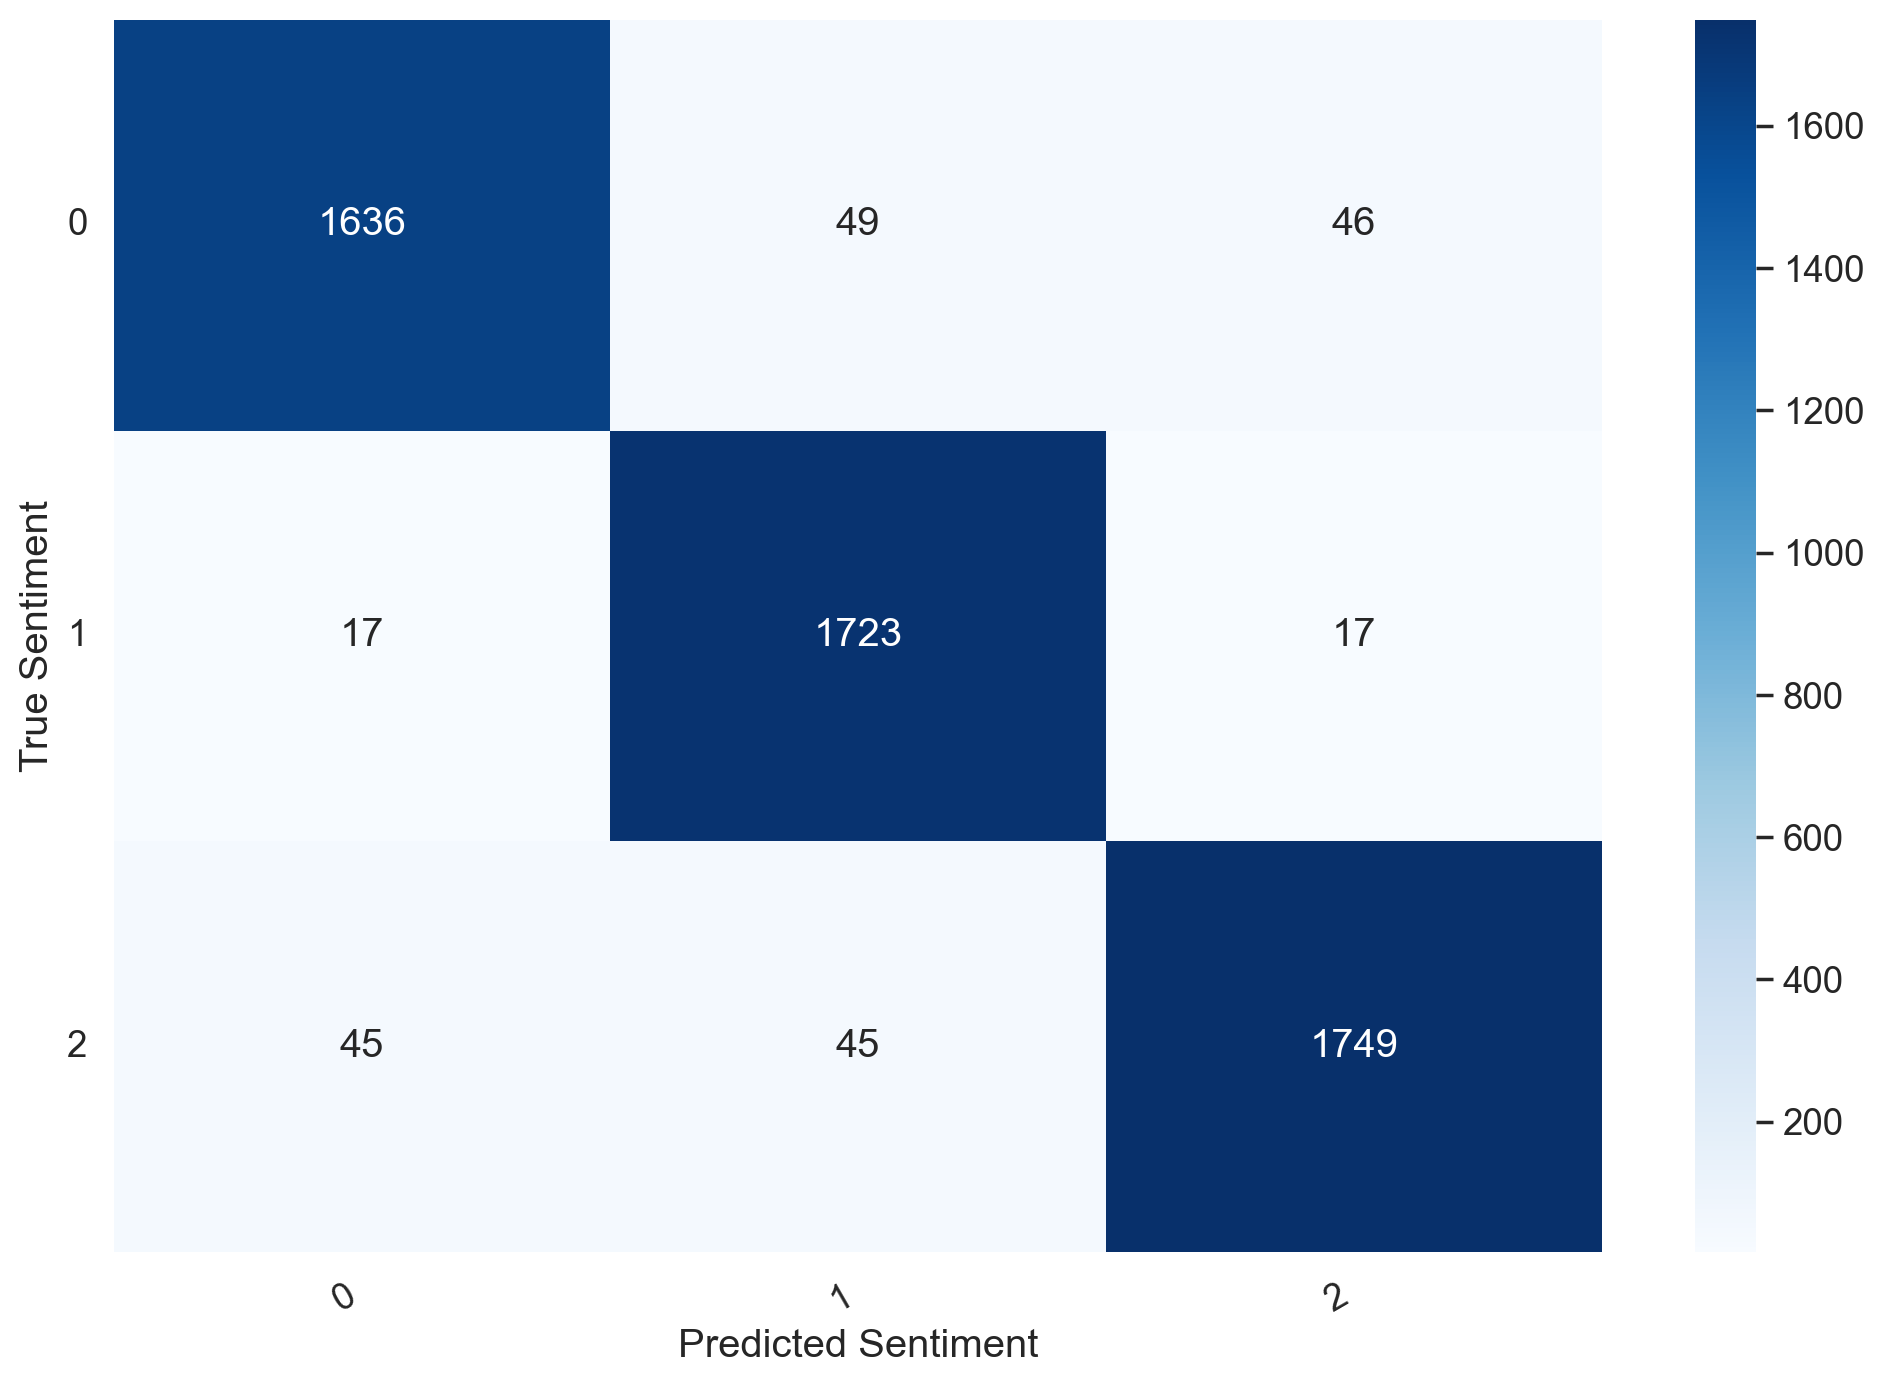

In [72]:
# Confusion matrix
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True Sentiment')
    plt.xlabel('Predicted Sentiment')

cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm)